pandas==2.2.2
yfinance==0.2.64
numpy==2.0.2
matplotlib==3.10.0
langchain-openai==0.3.27

# Setup

In [1]:
%cd /content/drive/MyDrive/Gen AI for Stock Analysis

/content/drive/MyDrive/Gen AI for Stock Analysis


In [86]:
import pandas as pd
import yfinance as yf
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# Load CSV File
df = pd.read_csv('assets july 7 2025.csv')
df.head()

Asset   Ticker     Units  Purchase Price Currency Purchase  \
0     S&P 500 ETF  SXR8.DE   17.4780          584.85               EUR   
1         Zalando   ZAL.DE  407.0000           44.08               EUR   
2  S&P 500 IT ETF  QDVE.DE  340.7460           30.68               EUR   
3         Bitcoin  BTC-USD    0.1279        44894.00               EUR   
4       Microsoft     MSFT    0.0389          384.06               EUR   

  Currency Yahoo  Price Last Update Date Last Update  Value Last Update  \
0            EUR             560.36       2025-06-30        9793.972080   
1            EUR              28.16       2025-06-30       11461.120000   
2            EUR              30.85       2025-06-30       10512.014100   
3            USD           91958.00       2025-06-30       11761.428200   
4            USD             422.55       2025-06-30          16.437195   

   Profit Last Update  
0         -428.036220  
1        -6479.440000  
2           57.926820  
3         6019.485600  
4            1.497261

In [61]:
# Preview info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Asset               5 non-null      object 
 1   Ticker              5 non-null      object 
 2   Units               5 non-null      float64
 3   Purchase Price      5 non-null      float64
 4   Currency Purchase   5 non-null      object 
 5   Currency Yahoo      5 non-null      object 
 6   Price Last Update   5 non-null      float64
 7   Date Last Update    5 non-null      object 
 8   Value Last Update   5 non-null      float64
 9   Profit Last Update  5 non-null      float64
dtypes: float64(5), object(5)
memory usage: 532.0+ bytes


# Compute Gains since last time

In [62]:
fx_pair = 'USDEUR=X'  # Yahoo Finance symbol for USD to EUR
fx_data = yf.Ticker(fx_pair).history(period="1d")
rate = fx_data['Close'].iloc[-1]
print(rate)

0.8522999882698059


In [63]:
# Fetch FX rate for USD → EUR
def get_fx_rate(from_currency: str, to_currency: str = 'EUR') -> float:
    """
    Get live FX rate from Yahoo. Returns 1.0 if from/to are the same.
    """
    if from_currency == to_currency:
        return 1.0
    pair = f"{from_currency}{to_currency}=X"
    try:
        fx_data = yf.Ticker(pair).history(period="1d")
        return fx_data['Close'].iloc[-1]
    except Exception:
        return np.nan

In [64]:
# test the get_fx_rate
print(get_fx_rate('USD', 'EUR'))

0.8522999882698059


In [65]:
# Cache FX rates with EUR = 1.0
fx_cache = {}
for ccy in df['Currency Yahoo'].unique():
    if ccy == 'EUR':
        fx_cache[ccy] = 1.0  # no conversion needed
    else:
        fx_cache[ccy] = get_fx_rate(ccy)
print("FX Cache:", fx_cache)

FX Cache: {'EUR': 1.0, 'USD': np.float64(0.8522999882698059)}


In [68]:
# Download one price from a ticker for a specific date
yf.Ticker('BTC-USD').history(period="1d")['Close']

Date
2025-07-07 00:00:00+00:00    108823.242188
Name: Close, dtype: float64

In [69]:
def get_price_eur(row) -> float:
    """
    Fetch Yahoo price in native currency and convert to EUR.
    """
    try:
        price_native = (
            yf.Ticker(row['Ticker'])
              .history(period="1d")['Close']
              .iloc[-1]
        )
        fx_rate = fx_cache.get(row['Currency Yahoo'], 1.0)  # default 1.0
        return price_native * fx_rate
    except Exception as e:
        print(f"Error fetching {row['Ticker']}: {e}")
        return np.nan

In [70]:
# get the price for all tickers
df.apply(get_price_eur, axis=1)

0      568.299988
1       28.010000
2       31.375000
3    92750.048040
4      425.161323
dtype: float64

In [71]:
# --- CALCULATIONS ---------------------------------------------
today = date.today()

df['Price Today (EUR)']       = df.apply(get_price_eur, axis=1)
df['Value Today (EUR)']       = df['Units'] * df['Price Today (EUR)']

df['Gain € Since Last']       = df['Value Today (EUR)'] - df['Value Last Update']
df['Gain € Since Purchase']   = df['Value Today (EUR)'] - df['Units'] * df['Purchase Price']

df['Gain % Since Last']       = df['Gain € Since Last']     / df['Value Last Update']                      * 100
df['Gain % Since Purchase']   = df['Gain € Since Purchase'] / (df['Units'] * df['Purchase Price'])         * 100


In [72]:
# --- Totals Row -----------------------------------------------
totals = {
    'Asset'                    : 'TOTAL',
    'Ticker'                   : '',
    'Gain € Since Last'        : df['Gain € Since Last'].sum(),
    'Gain % Since Last'        : df['Gain € Since Last'].sum()     / df['Value Last Update'].sum()           * 100,
    'Gain € Since Purchase'    : df['Gain € Since Purchase'].sum(),
    'Gain % Since Purchase'    : df['Gain € Since Purchase'].sum() / (df['Units']*df['Purchase Price']).sum()* 100,
}

In [73]:
# Columns to show
report_cols = [
    'Asset', 'Ticker',
    'Gain € Since Last', 'Gain % Since Last',
    'Gain € Since Purchase', 'Gain % Since Purchase'
]

report = pd.concat([df[report_cols], pd.DataFrame([totals])], ignore_index=True)

In [74]:
# --- Print Report ---------------------------------------------
print(f"\nSnapshot as of {today} (all converted to EUR):\n")
print(report.to_string(index=False, float_format='{:,.2f}'.format))


Snapshot as of 2025-07-07 (all converted to EUR):

         Asset  Ticker  Gain € Since Last  Gain % Since Last  Gain € Since Purchase  Gain % Since Purchase
   S&P 500 ETF SXR8.DE             138.78               1.42                -289.26                  -2.83
       Zalando  ZAL.DE             -61.05              -0.53              -6,540.49                 -36.46
S&P 500 IT ETF QDVE.DE             178.89               1.70                 236.82                   2.27
       Bitcoin BTC-USD             101.30               0.86               6,120.79                 106.60
     Microsoft    MSFT               0.10               0.62                   1.60                  10.70
         TOTAL                     358.02               0.82                -470.55                  -1.06


# Portfolio Updates

In [76]:
# --- STEP 1: Update existing assets --------------------------------
while True:
    resp = input("\n📥 Were there additional purchases for existing assets? (y/n): ").strip().lower()
    if resp != 'y':
        print("✅ No updates for existing assets.")
        break

    print("\nCurrent portfolio assets:")
    for asset in df['Asset']:
        print(f"- {asset}")

    asset_name = input("\nWhich asset was updated? (type asset name): ").strip()

    # Check if asset exists
    if asset_name not in df['Asset'].values:
        print(f"❌ Asset '{asset_name}' not found in portfolio. Try again.")
        continue

    # Ask for units and price
    try:
        extra_units = float(input("How many new units were bought?: "))
        purchase_price = float(input("What was the purchase price per unit (EUR)?: "))

        # Update units and average purchase price
        idx = df[df['Asset'] == asset_name].index[0]
        old_units = df.at[idx, 'Units']
        old_avg_price = df.at[idx, 'Purchase Price']

        total_cost = (old_units * old_avg_price) + (extra_units * purchase_price)
        total_units = old_units + extra_units
        new_avg_price = total_cost / total_units

        # Update DataFrame
        df.at[idx, 'Units'] = total_units
        df.at[idx, 'Purchase Price'] = new_avg_price

        print(f"✅ Updated {asset_name}: {total_units:.4f} units @ avg price €{new_avg_price:.2f}")

    except Exception as e:
        print("⚠ Error: Please check your input.", e)


📥 Were there additional purchases for existing assets? (y/n): y

Current portfolio assets:
- S&P 500 ETF
- Zalando
- S&P 500 IT ETF
- Bitcoin
- Microsoft

Which asset was updated? (type asset name): Bitcoin
How many new units were bought?: 0.01
What was the purchase price per unit (EUR)?: 92000
✅ Updated Bitcoin: 0.1379 units @ avg price €48309.95

📥 Were there additional purchases for existing assets? (y/n): n
✅ No updates for existing assets.


In [78]:
# --- STEP 2: Add new assets to portfolio --------------------------
while True:
    resp = input("\n➕ Are there new assets to add to the portfolio? (y/n): ").strip().lower()
    if resp != 'y':
        print("✅ No new assets added.")
        break

    try:
        asset_name = input("Asset name: ").strip()
        ticker = input("Ticker (Yahoo Finance): ").strip()
        units = float(input("Units bought: "))
        purchase_price = float(input("Purchase price per unit (EUR): "))
        currency_yahoo = input("Currency in Yahoo Finance (EUR/USD/etc): ").strip().upper()

        # Create new row
        new_row = {
            'Asset': asset_name,
            'Ticker': ticker,
            'Units': units,
            'Purchase Price': purchase_price,
            'Currency Purchase': 'EUR',
            'Currency Yahoo': currency_yahoo,
            'Price Last Update': np.nan,
            'Date Last Update': np.nan,
            'Value Last Update': np.nan,
            'Profit Last Update': np.nan
        }

        # Append to DataFrame
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        print(f"✅ Added {asset_name} to portfolio.")

    except Exception as e:
        print("⚠ Error: Please check your input.", e)



➕ Are there new assets to add to the portfolio? (y/n): y
Asset name: AAPL
Ticker (Yahoo Finance): AAPL
Units bought: 1
Purchase price per unit (EUR): 250
Currency in Yahoo Finance (EUR/USD/etc): USD
✅ Added AAPL to portfolio.

➕ Are there new assets to add to the portfolio? (y/n): n
✅ No new assets added.


# Portfolio Analysis

## Moving Average vs Price

In [83]:
# --- Fetch historical prices ------------------------------------------
def get_history(ticker, period="1y", interval="1d"):
    """
    Fetch historical price data for a ticker.
    """
    try:
        symbol = ticker
        hist = yf.Ticker(symbol).history(period=period, interval=interval)
        return hist
    except Exception as e:
        print(f"⚠ Error fetching history for {ticker}: {e}")
        return None

In [85]:
# --- Compute moving averages ------------------------------------------
def compute_moving_averages(ticker):
    """
    Fetch price data and compute 50, 100, 200-day moving averages.
    """
    hist = get_history(ticker, period="1y")
    if hist is None or hist.empty:
        print(f"⚠ No price data for {ticker}.")
        return None

    # Calculate moving averages
    hist['MA50']  = hist['Close'].rolling(window=50).mean()
    hist['MA100'] = hist['Close'].rolling(window=100).mean()
    hist['MA200'] = hist['Close'].rolling(window=200).mean()

    # Latest price and moving averages
    latest_price = hist['Close'].iloc[-1]
    latest_ma50  = hist['MA50'].iloc[-1]
    latest_ma100 = hist['MA100'].iloc[-1]
    latest_ma200 = hist['MA200'].iloc[-1]

    print(f"\n📊 {ticker} - Moving Averages vs Price")
    print(f"  Current Price: €{latest_price:.2f}")
    print(f"  MA-50: €{latest_ma50:.2f} ({'Above' if latest_price > latest_ma50 else 'Below'})")
    print(f"  MA-100: €{latest_ma100:.2f} ({'Above' if latest_price > latest_ma100 else 'Below'})")
    print(f"  MA-200: €{latest_ma200:.2f} ({'Above' if latest_price > latest_ma200 else 'Below'})")

    return hist

In [87]:
def plot_moving_averages(hist, ticker):
    """
    Plot closing price and moving averages.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist['Close'], label='Close Price', linewidth=2)
    plt.plot(hist.index, hist['MA50'], label='50-Day MA', linestyle='--')
    plt.plot(hist.index, hist['MA100'], label='100-Day MA', linestyle='-.')
    plt.plot(hist.index, hist['MA200'], label='200-Day MA', linestyle=':')
    plt.title(f"{ticker} Price and Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (EUR)")
    plt.legend()
    plt.grid(True)
    plt.show()


📊 SXR8.DE - Moving Averages vs Price
  Current Price: €568.80
  MA-50: €550.22 (Above)
  MA-100: €554.45 (Above)
  MA-200: €571.98 (Below)


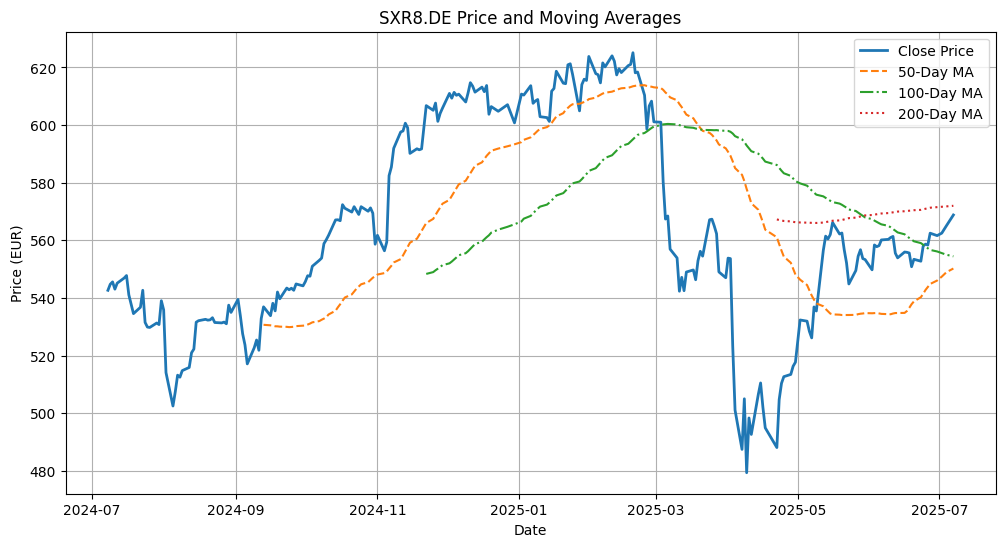


📊 ZAL.DE - Moving Averages vs Price
  Current Price: €28.03
  MA-50: €29.99 (Below)
  MA-100: €31.81 (Below)
  MA-200: €31.35 (Below)


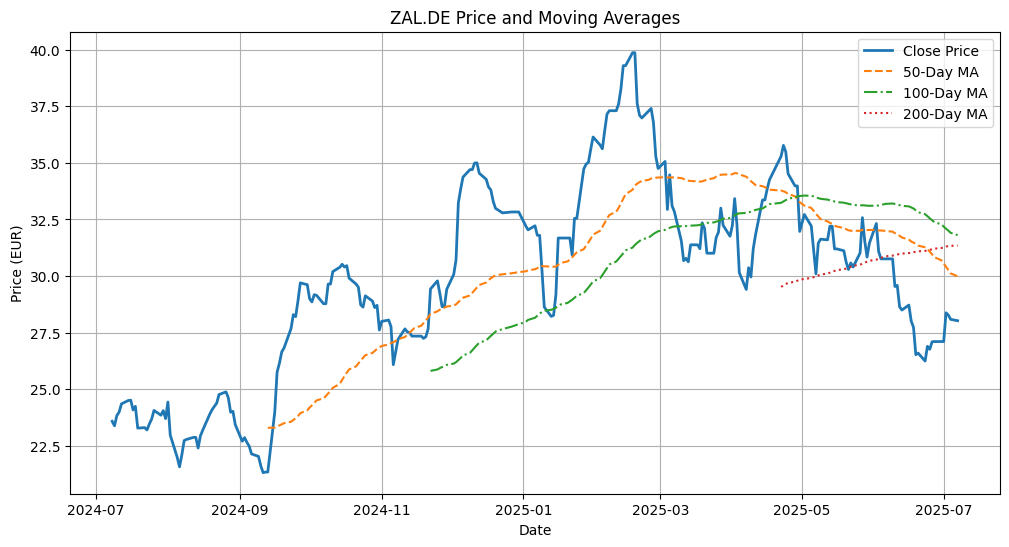


📊 QDVE.DE - Moving Averages vs Price
  Current Price: €31.42
  MA-50: €29.23 (Above)
  MA-100: €28.83 (Above)
  MA-200: €30.04 (Above)


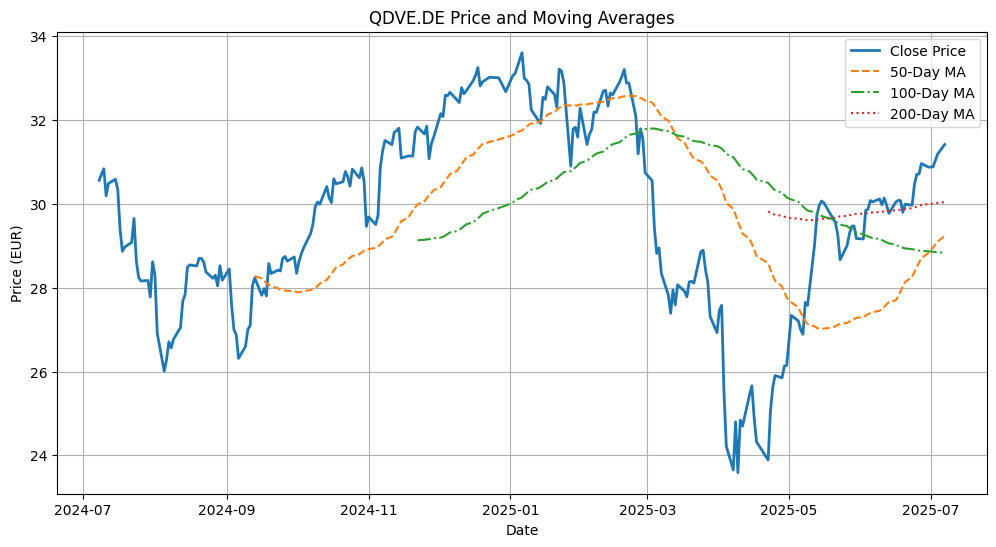


📊 BTC-USD - Moving Averages vs Price
  Current Price: €108776.99
  MA-50: €106632.33 (Above)
  MA-100: €99045.32 (Above)
  MA-200: €96461.98 (Above)


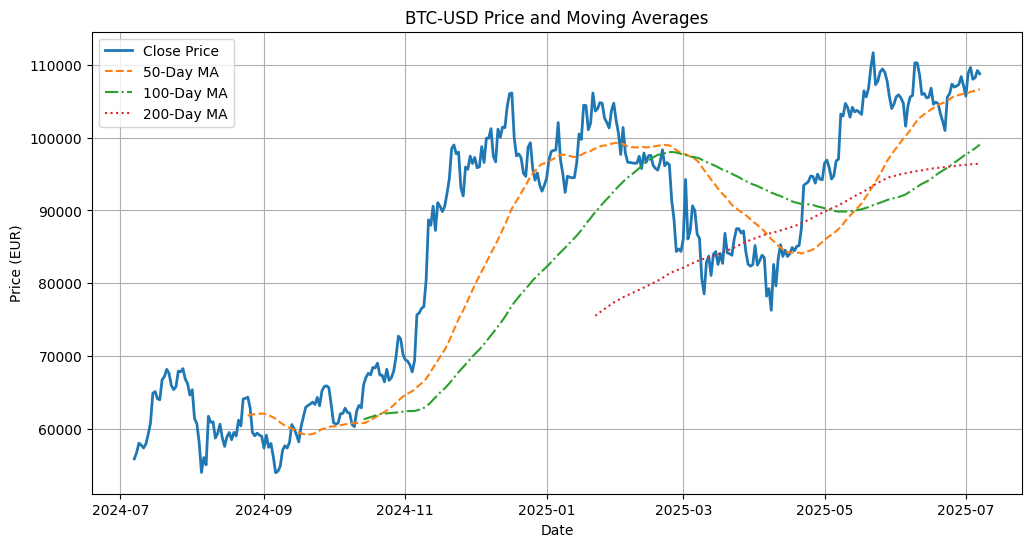


📊 MSFT - Moving Averages vs Price
  Current Price: €498.84
  MA-50: €455.71 (Above)
  MA-100: €421.85 (Above)
  MA-200: €423.14 (Above)


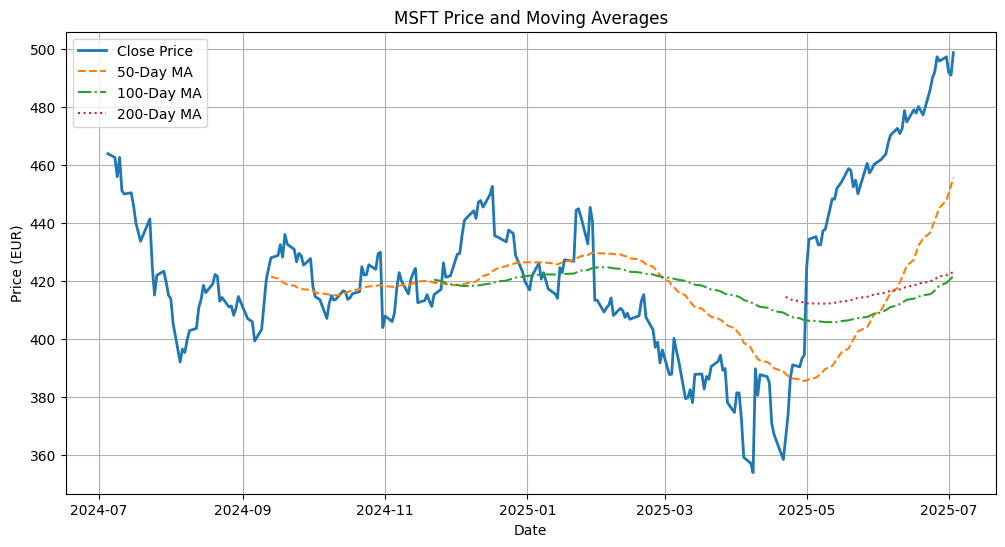


📊 AAPL - Moving Averages vs Price
  Current Price: €213.55
  MA-50: €203.65 (Above)
  MA-100: €211.91 (Above)
  MA-200: €222.67 (Below)


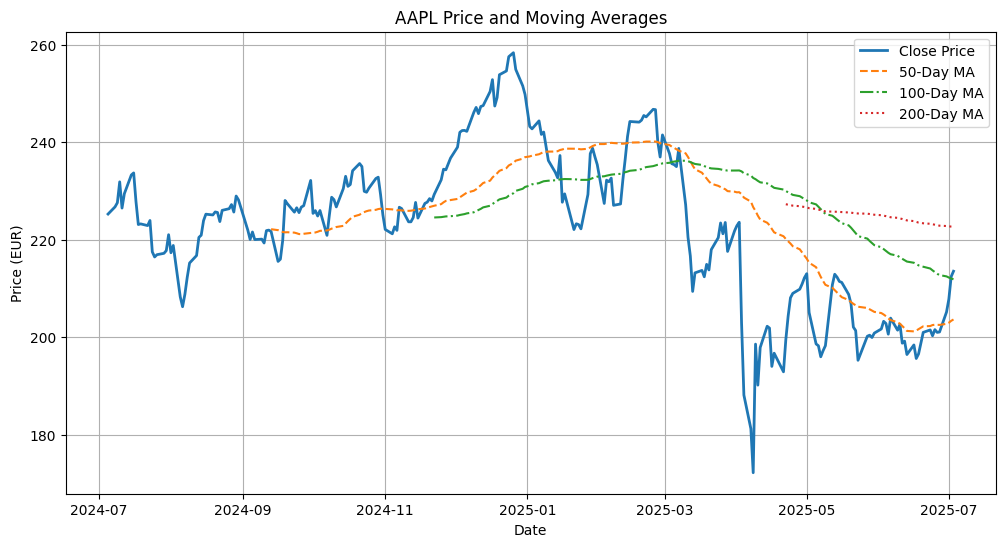

In [89]:
# plot for all tickers in my portfolio
for ticker in df['Ticker']:
    hist = compute_moving_averages(ticker)
    if hist is not None:
        plot_moving_averages(hist, ticker)


## Volatility

In [95]:
def compute_volatility(ticker, window=30):
    """
    Calculate rolling volatility (% annualized) for a ticker.
    """
    hist = yf.Ticker(ticker).history(period="6mo", interval="1d")
    if hist.empty:
        print(f"⚠ No data for {ticker}.")
        return None

    # Daily returns
    returns = hist['Close'].pct_change().dropna()

    # Rolling volatility (std dev)
    rolling_vol = returns.rolling(window=window).std() * np.sqrt(252) * 100  # Annualized %

    # Latest volatility value
    latest_vol = rolling_vol.iloc[-1]
    print(f"📊 {ticker} - {window}-day Volatility: {latest_vol:.2f}%")

    return latest_vol, rolling_vol, hist


In [96]:
# Portfolio tickers
tickers = df['Ticker'].tolist()

# Store results
volatility_results = {}

for ticker in tickers:
    result = compute_volatility(ticker)
    if result:
        latest_vol, rolling_vol, hist = result
        volatility_results[ticker] = {
            "latest_vol": latest_vol,
            "rolling_vol": rolling_vol,
            "price_history": hist
        }

📊 SXR8.DE - 30-day Volatility: 9.76%
📊 ZAL.DE - 30-day Volatility: 36.07%
📊 QDVE.DE - 30-day Volatility: 13.55%
📊 BTC-USD - 30-day Volatility: 25.69%
📊 MSFT - 30-day Volatility: 13.57%
📊 AAPL - 30-day Volatility: 21.50%


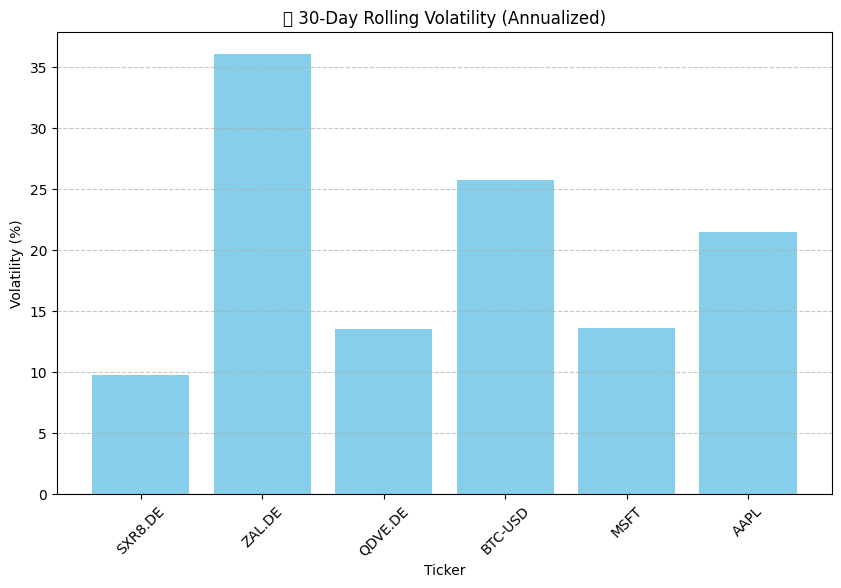

In [97]:
# Bar chart of latest volatilities
import matplotlib.pyplot as plt

# Extract tickers and volatilities
tickers_list = list(volatility_results.keys())
vol_values = [volatility_results[t]['latest_vol'] for t in tickers_list]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(tickers_list, vol_values, color='skyblue')
plt.title("📈 30-Day Rolling Volatility (Annualized)")
plt.ylabel("Volatility (%)")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## P/E Ratio

In [98]:
# --- Fetch P/E ratio for all tickers -------------------------------
pe_ratios = {}

for ticker in df['Ticker']:
    try:
        info = yf.Ticker(ticker).info
        pe = info.get('trailingPE', np.nan)
        if np.isnan(pe):
            print(f"⚠ {ticker} has no P/E ratio (possibly negative earnings or ETF).")
        else:
            print(f"📊 {ticker} - P/E Ratio: {pe:.2f}")
        pe_ratios[ticker] = pe
    except Exception as e:
        print(f"⚠ Error fetching P/E for {ticker}: {e}")
        pe_ratios[ticker] = np.nan

⚠ SXR8.DE has no P/E ratio (possibly negative earnings).
📊 ZAL.DE - P/E Ratio: 27.21
⚠ QDVE.DE has no P/E ratio (possibly negative earnings).
⚠ BTC-USD has no P/E ratio (possibly negative earnings).
📊 MSFT - P/E Ratio: 38.61
📊 AAPL - P/E Ratio: 33.21


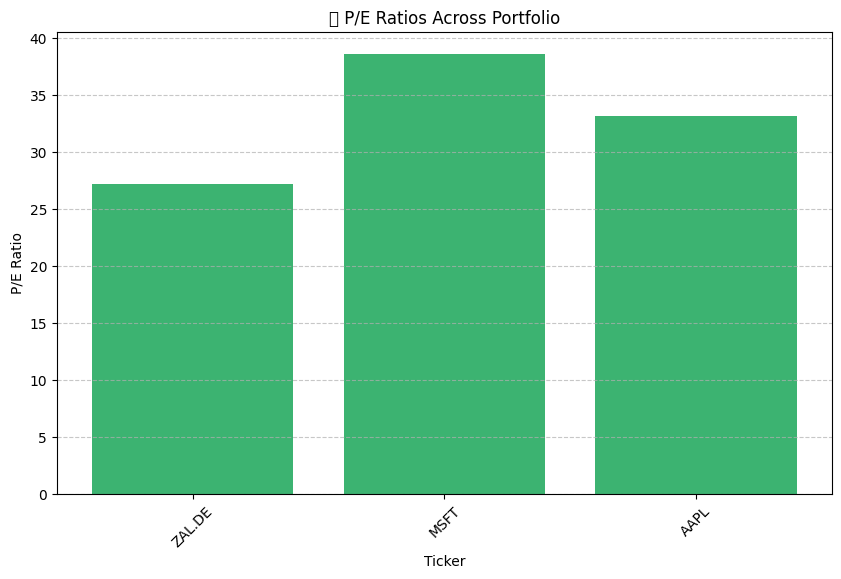

In [99]:
# --- Bar chart of P/E ratios ---------------------------------------
import matplotlib.pyplot as plt

# Filter out tickers with NaN P/E
valid_pe = {k: v for k, v in pe_ratios.items() if not np.isnan(v)}

if valid_pe:
    tickers_pe = list(valid_pe.keys())
    pe_values = list(valid_pe.values())

    plt.figure(figsize=(10, 6))
    plt.bar(tickers_pe, pe_values, color='mediumseagreen')
    plt.title("💰 P/E Ratios Across Portfolio")
    plt.ylabel("P/E Ratio")
    plt.xlabel("Ticker")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("⚠ No valid P/E ratios to display.")


## BETA

In [100]:
# --- Fetch Beta for all tickers ------------------------------------
beta_values = {}

for ticker in df['Ticker']:
    try:
        info = yf.Ticker(ticker).info
        beta = info.get('beta', np.nan)
        if np.isnan(beta):
            print(f"⚠ {ticker} has no Beta value.")
        else:
            print(f"📊 {ticker} - Beta: {beta:.2f}")
        beta_values[ticker] = beta
    except Exception as e:
        print(f"⚠ Error fetching Beta for {ticker}: {e}")
        beta_values[ticker] = np.nan

⚠ SXR8.DE has no Beta value.
📊 ZAL.DE - Beta: 1.60
⚠ QDVE.DE has no Beta value.
⚠ BTC-USD has no Beta value.
📊 MSFT - Beta: 1.03
📊 AAPL - Beta: 1.21


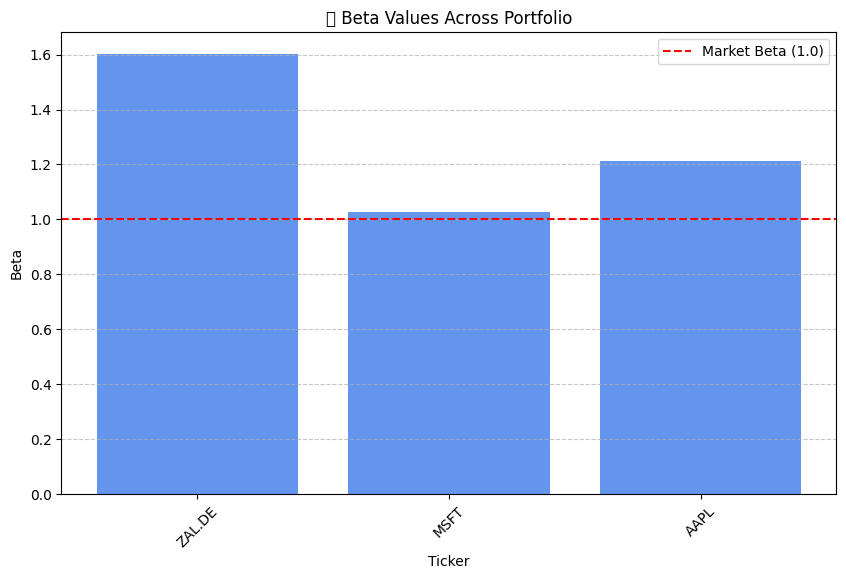

In [101]:
# --- Bar chart of Beta values -------------------------------------
import matplotlib.pyplot as plt

# Filter out tickers with NaN Beta
valid_beta = {k: v for k, v in beta_values.items() if not np.isnan(v)}

if valid_beta:
    tickers_beta = list(valid_beta.keys())
    beta_vals = list(valid_beta.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(tickers_beta, beta_vals, color='cornflowerblue')
    plt.axhline(y=1, color='red', linestyle='--', label='Market Beta (1.0)')
    plt.title("📊 Beta Values Across Portfolio")
    plt.ylabel("Beta")
    plt.xlabel("Ticker")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("⚠ No valid Beta values to display.")


## Sharpe Ratio

In [102]:
# --- Compute Sharpe Ratio for all tickers -------------------------
sharpe_ratios = {}
risk_free_rate = 0.04  # Assume 2% annualized risk-free rate

for ticker in df['Ticker']:
    try:
        # Fetch price history (1 year)
        hist = yf.Ticker(ticker).history(period="1y")
        if hist.empty:
            print(f"⚠ No price data for {ticker}.")
            sharpe_ratios[ticker] = np.nan
            continue

        # Daily returns
        daily_returns = hist['Close'].pct_change().dropna()

        # Annualized return & volatility
        avg_daily_return = daily_returns.mean()
        annualized_return = avg_daily_return * 252
        volatility = daily_returns.std() * np.sqrt(252)

        # Sharpe ratio
        sharpe = (annualized_return - risk_free_rate) / volatility if volatility != 0 else np.nan

        sharpe_ratios[ticker] = sharpe
        print(f"📈 {ticker} - Sharpe Ratio: {sharpe:.2f}")

    except Exception as e:
        print(f"⚠ Error computing Sharpe for {ticker}: {e}")
        sharpe_ratios[ticker] = np.nan


📈 SXR8.DE - Sharpe Ratio: 0.14
📈 ZAL.DE - Sharpe Ratio: 0.53
📈 QDVE.DE - Sharpe Ratio: 0.10
📈 BTC-USD - Sharpe Ratio: 1.23
📈 MSFT - Sharpe Ratio: 0.26
📈 AAPL - Sharpe Ratio: -0.13


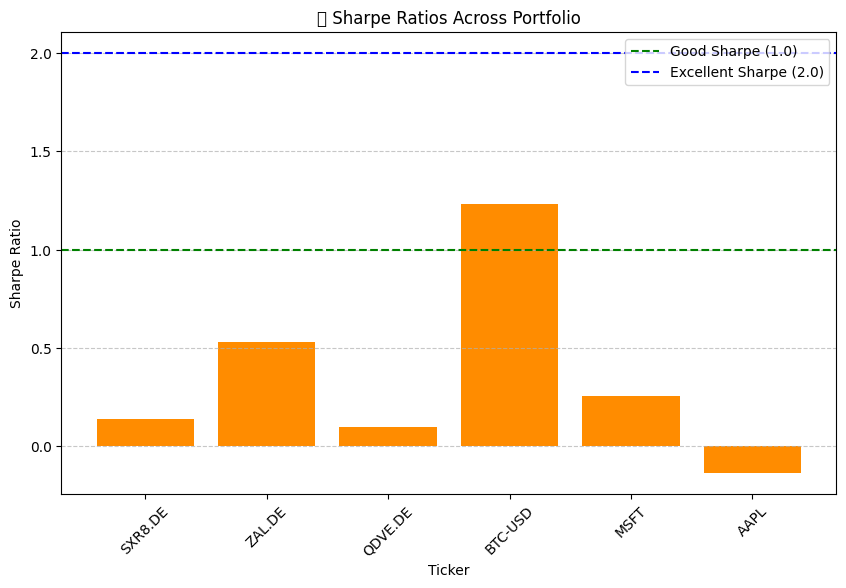

In [103]:
# --- Bar chart of Sharpe Ratios ------------------------------------
import matplotlib.pyplot as plt

# Filter out NaNs
valid_sharpe = {k: v for k, v in sharpe_ratios.items() if not np.isnan(v)}

if valid_sharpe:
    tickers_sharpe = list(valid_sharpe.keys())
    sharpe_vals = list(valid_sharpe.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(tickers_sharpe, sharpe_vals, color='darkorange')
    plt.axhline(y=1, color='green', linestyle='--', label='Good Sharpe (1.0)')
    plt.axhline(y=2, color='blue', linestyle='--', label='Excellent Sharpe (2.0)')
    plt.title("📈 Sharpe Ratios Across Portfolio")
    plt.ylabel("Sharpe Ratio")
    plt.xlabel("Ticker")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("⚠ No valid Sharpe ratios to display.")


## RSI

In [104]:
# --- Compute RSI for all tickers ------------------------------------
rsi_values = {}

def compute_rsi(series, period=14):
    """
    Compute RSI (Relative Strength Index) for a price series.
    """
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Loop through portfolio
for ticker in df['Ticker']:
    try:
        hist = yf.Ticker(ticker).history(period="3mo")
        if hist.empty:
            print(f"⚠ No price data for {ticker}.")
            rsi_values[ticker] = np.nan
            continue

        close_prices = hist['Close']
        rsi_series = compute_rsi(close_prices)
        latest_rsi = rsi_series.iloc[-1]

        rsi_values[ticker] = latest_rsi
        print(f"🔄 {ticker} - RSI: {latest_rsi:.2f}")

    except Exception as e:
        print(f"⚠ Error computing RSI for {ticker}: {e}")
        rsi_values[ticker] = np.nan


🔄 SXR8.DE - RSI: 76.19
🔄 ZAL.DE - RSI: 50.11
🔄 QDVE.DE - RSI: 84.04
🔄 BTC-USD - RSI: 61.55
🔄 MSFT - RSI: 69.45
🔄 AAPL - RSI: 74.80


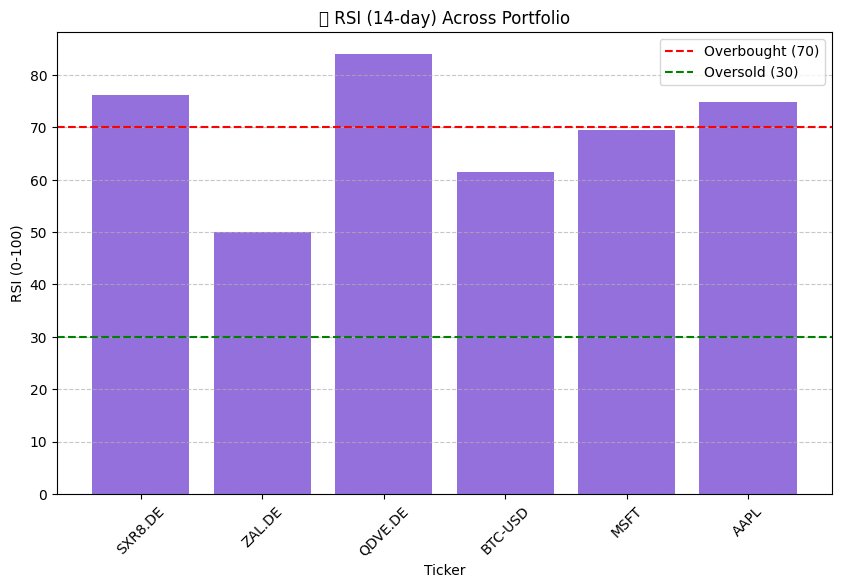

In [105]:
# --- Bar chart of RSI values ---------------------------------------
import matplotlib.pyplot as plt

# Filter out NaNs
valid_rsi = {k: v for k, v in rsi_values.items() if not np.isnan(v)}

if valid_rsi:
    tickers_rsi = list(valid_rsi.keys())
    rsi_vals = list(valid_rsi.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(tickers_rsi, rsi_vals, color='mediumpurple')
    plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    plt.title("🔄 RSI (14-day) Across Portfolio")
    plt.ylabel("RSI (0-100)")
    plt.xlabel("Ticker")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("⚠ No valid RSI values to display.")


## MACD Crossover

In [106]:
# --- Compute MACD for all tickers -----------------------------------
macd_crossovers = {}

def compute_macd(series, slow=26, fast=12, signal=9):
    """
    Compute MACD line and Signal line, detect crossover.
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()

    # Detect latest crossover
    last_macd = macd_line.iloc[-1]
    last_signal = signal_line.iloc[-1]
    crossover = "Bullish" if last_macd > last_signal else "Bearish"

    return last_macd, last_signal, crossover

# Loop through portfolio
for ticker in df['Ticker']:
    try:
        hist = yf.Ticker(ticker).history(period="3mo")
        if hist.empty:
            print(f"⚠ No price data for {ticker}.")
            macd_crossovers[ticker] = None
            continue

        close_prices = hist['Close']
        macd_val, signal_val, crossover = compute_macd(close_prices)

        macd_crossovers[ticker] = {
            "MACD": macd_val,
            "Signal": signal_val,
            "Crossover": crossover
        }

        print(f"📈 {ticker} - MACD: {macd_val:.2f}, Signal: {signal_val:.2f}, Crossover: {crossover}")

    except Exception as e:
        print(f"⚠ Error computing MACD for {ticker}: {e}")
        macd_crossovers[ticker] = None


📈 SXR8.DE - MACD: 4.34, Signal: 3.94, Crossover: Bullish
📈 ZAL.DE - MACD: -0.63, Signal: -0.87, Crossover: Bullish
📈 QDVE.DE - MACD: 0.57, Signal: 0.54, Crossover: Bullish
📈 BTC-USD - MACD: 947.19, Signal: 740.54, Crossover: Bullish
📈 MSFT - MACD: 12.10, Signal: 12.72, Crossover: Bearish
📈 AAPL - MACD: 2.06, Signal: 0.47, Crossover: Bullish


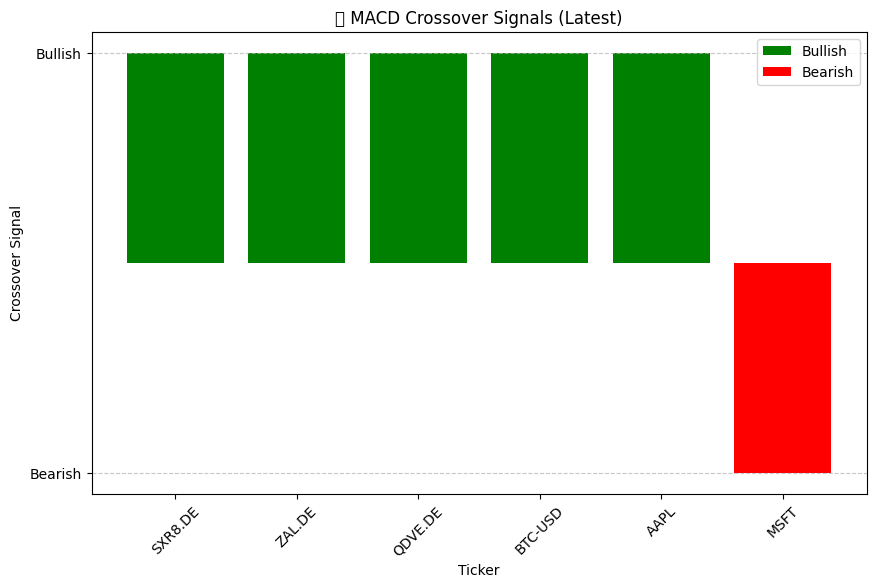

In [107]:
# --- Bar chart showing MACD crossovers ----------------------------
import matplotlib.pyplot as plt

bullish = [ticker for ticker, val in macd_crossovers.items() if val and val['Crossover'] == 'Bullish']
bearish = [ticker for ticker, val in macd_crossovers.items() if val and val['Crossover'] == 'Bearish']

plt.figure(figsize=(10, 6))
plt.bar(bullish, [1]*len(bullish), color='green', label='Bullish')
plt.bar(bearish, [-1]*len(bearish), color='red', label='Bearish')
plt.title("📊 MACD Crossover Signals (Latest)")
plt.ylabel("Crossover Signal")
plt.xlabel("Ticker")
plt.yticks([-1, 1], ['Bearish', 'Bullish'])
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Analysis and Recommendations

In [114]:
!pip install langchain_openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 1.6 MB/s eta 0:00:00


In [120]:
from google.colab import userdata
import os
api_key = userdata.get('OPENAI_API_KEY')

# set key in os
os.environ['OPENAI_API_KEY'] = api_key

from langchain_openai import ChatOpenAI
from IPython.display import Markdown

In [116]:
llm = ChatOpenAI(
    model="gpt-4.1",
    temperature=0)

In [118]:
# Combine all KPI dictionaries into a single DataFrame
kpi_df = pd.DataFrame({
    'Ticker': df['Ticker'],
    'Asset': df['Asset'],
    'Price Today': df['Price Today (EUR)'],
    'MA-50': [compute_moving_averages(t)['Close'].rolling(50).mean().iloc[-1] for t in df['Ticker']],
    'MA-100': [compute_moving_averages(t)['Close'].rolling(100).mean().iloc[-1] for t in df['Ticker']],
    'MA-200': [compute_moving_averages(t)['Close'].rolling(200).mean().iloc[-1] for t in df['Ticker']],
    'Volatility (30d)': [volatility_results[t]['latest_vol'] for t in df['Ticker']],
    'P/E Ratio': [pe_ratios.get(t, np.nan) for t in df['Ticker']],
    'Beta': [beta_values.get(t, np.nan) for t in df['Ticker']],
    'Sharpe Ratio': [sharpe_ratios.get(t, np.nan) for t in df['Ticker']],
    'RSI': [rsi_values.get(t, np.nan) for t in df['Ticker']],
    'MACD Crossover': [macd_crossovers.get(t, {}).get('Crossover', 'N/A') for t in df['Ticker']]
})

# Preview combined KPI table
kpi_df.to_string()



📊 SXR8.DE - Moving Averages vs Price
  Current Price: €569.02
  MA-50: €550.22 (Above)
  MA-100: €554.45 (Above)
  MA-200: €571.99 (Below)

📊 ZAL.DE - Moving Averages vs Price
  Current Price: €28.09
  MA-50: €29.99 (Below)
  MA-100: €31.81 (Below)
  MA-200: €31.35 (Below)

📊 QDVE.DE - Moving Averages vs Price
  Current Price: €31.45
  MA-50: €29.23 (Above)
  MA-100: €28.84 (Above)
  MA-200: €30.04 (Above)

📊 BTC-USD - Moving Averages vs Price
  Current Price: €108698.44
  MA-50: €106630.75 (Above)
  MA-100: €99044.54 (Above)
  MA-200: €96461.59 (Above)

📊 MSFT - Moving Averages vs Price
  Current Price: €498.84
  MA-50: €455.71 (Above)
  MA-100: €421.85 (Above)
  MA-200: €423.14 (Above)

📊 AAPL - Moving Averages vs Price
  Current Price: €213.55
  MA-50: €203.65 (Above)
  MA-100: €211.91 (Above)
  MA-200: €222.67 (Below)

📊 SXR8.DE - Moving Averages vs Price
  Current Price: €569.02
  MA-50: €550.22 (Above)
  MA-100: €554.45 (Above)
  MA-200: €571.99 (Below)

📊 ZAL.DE - Moving Averag

'    Ticker           Asset   Price Today          MA-50        MA-100        MA-200  Volatility (30d)  P/E Ratio   Beta  Sharpe Ratio        RSI MACD Crossover\n0  SXR8.DE     S&P 500 ETF    568.299988     550.223599    554.448598    571.985699          9.763501        NaN    NaN      0.138886  76.187366        Bullish\n1   ZAL.DE         Zalando     28.010000      29.990800     31.808800     31.346550         36.068085  27.213594  1.602      0.529664  50.107529        Bullish\n2  QDVE.DE  S&P 500 IT ETF     31.375000      29.233700     28.835250     30.043325         13.553196        NaN    NaN      0.096715  84.040336        Bullish\n3  BTC-USD         Bitcoin  92750.048040  106630.754844  99044.538672  96461.590156         25.692290        NaN    NaN      1.230393  61.553220        Bullish\n4     MSFT       Microsoft    425.161323     455.710704    421.852448    423.140566         13.574566  38.609905  1.026      0.256499  69.452545        Bearish\n5     AAPL            AAPL       

In [117]:
instruction = """
You are a portfolio analyst.

For every ticker:
• Summarise key strengths & risks based on MA vs price, volatility, P/E, Beta, Sharpe, RSI, MACD.
• Flag momentum signals: RSI (>70 overbought, <30 oversold) and MACD crossovers.
• Recommend: 'Buy', 'Hold', or 'Reduce', with 1–2 line rationale.

Finish with a brief overall portfolio note.
Return the answer as readable markdown.
"""

In [119]:
messages = [
    (
        "system",
        instruction,
    ),
    ("human", kpi_df.to_string()
),
]

In [122]:
ai_msg = llm.invoke(messages)
Markdown(ai_msg.content)

```markdown
## Portfolio Analysis

---

### 1. SXR8.DE (S&P 500 ETF)
- **Strengths:** Price above MA-50/MA-100, close to MA-200; low volatility (9.8%); positive Sharpe (0.14); bullish MACD.
- **Risks:** RSI at 76.2 (overbought); potential for short-term pullback.
- **Momentum Signals:** **RSI > 70 (overbought)**, **MACD Bullish**.
- **Recommendation:** **Hold**  
  *Rationale: Strong uptrend but overbought; wait for a better entry.*

---

### 2. ZAL.DE (Zalando)
- **Strengths:** Sharpe (0.53) and Beta (1.60) suggest good risk-adjusted returns; bullish MACD.
- **Risks:** Price below all MAs (weak technicals); high volatility (36%); neutral RSI (50).
- **Momentum Signals:** **MACD Bullish**.
- **Recommendation:** **Hold**  
  *Rationale: Improving momentum, but technicals still weak; monitor for sustained reversal.*

---

### 3. QDVE.DE (S&P 500 IT ETF)
- **Strengths:** Price above all MAs; moderate volatility (13.6%); bullish MACD.
- **Risks:** RSI at 84 (strongly overbought); Sharpe (0.10) is low.
- **Momentum Signals:** **RSI > 70 (overbought)**, **MACD Bullish**.
- **Recommendation:** **Reduce**  
  *Rationale: Overbought with limited risk-adjusted return; consider trimming.*

---

### 4. BTC-USD (Bitcoin)
- **Strengths:** High Sharpe (1.23); bullish MACD; price above MA-200.
- **Risks:** Price below MA-50/MA-100 (short-term weakness); high volatility (25.7%); RSI neutral (61.6).
- **Momentum Signals:** **MACD Bullish**.
- **Recommendation:** **Hold**  
  *Rationale: Long-term uptrend, but short-term consolidation; maintain position.*

---

### 5. MSFT (Microsoft)
- **Strengths:** Price near MA-100/MA-200; moderate volatility (13.6%); strong fundamentals (P/E 38.6); Sharpe positive (0.26).
- **Risks:** Price below MA-50 (short-term weakness); RSI at 69.5 (near overbought); bearish MACD.
- **Momentum Signals:** **MACD Bearish**.
- **Recommendation:** **Hold**  
  *Rationale: Quality stock, but short-term momentum is weak; wait for technical improvement.*

---

### 6. AAPL (Apple)
- **Strengths:** N/A (price not provided); strong brand; moderate volatility (21.5%).
- **Risks:** RSI at 74.8 (overbought); negative Sharpe (-0.13); price likely below MAs; bullish MACD.
- **Momentum Signals:** **RSI > 70 (overbought)**, **MACD Bullish**.
- **Recommendation:** **Reduce**  
  *Rationale: Overbought and negative risk-adjusted return; consider reducing exposure.*

---

## Portfolio Note

The portfolio shows strong momentum in US equities and tech, but several positions are overbought (RSI > 70), suggesting caution. Risk-adjusted returns are mixed, with some negative Sharpe ratios. Consider trimming overextended positions and rebalancing towards assets with better entry points and more favorable risk/reward profiles.
```


# New Possible Stock Analysis

In [170]:
# --- New tickers to analyze ----------------------------------------
new_tickers = ['AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA']

# Create placeholder dictionaries for KPI results
new_volatility_results = {}
new_pe_ratios = {}
new_beta_values = {}
new_sharpe_ratios = {}
new_rsi_values = {}
new_macd_crossovers = {}

# --- Compute KPIs for each new ticker -----------------------------
for ticker in new_tickers:
    print(f"\n📊 Analyzing {ticker}")

    # Volatility
    result = compute_volatility(ticker)
    if result:
        latest_vol, rolling_vol, hist = result
        new_volatility_results[ticker] = {
            "latest_vol": latest_vol,
            "rolling_vol": rolling_vol,
            "price_history": hist
        }

    # P/E Ratio
    try:
        info = yf.Ticker(ticker).info
        pe = info.get('trailingPE', np.nan)
        new_pe_ratios[ticker] = pe
    except Exception:
        new_pe_ratios[ticker] = np.nan

    # Beta
    try:
        beta = info.get('beta', np.nan)
        new_beta_values[ticker] = beta
    except Exception:
        new_beta_values[ticker] = np.nan

    # Sharpe Ratio
    try:
        hist = yf.Ticker(ticker).history(period="1y")
        daily_returns = hist['Close'].pct_change().dropna()
        avg_daily_return = daily_returns.mean()
        annualized_return = avg_daily_return * 252
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe = (annualized_return - risk_free_rate) / volatility if volatility != 0 else np.nan
        new_sharpe_ratios[ticker] = sharpe
    except Exception:
        new_sharpe_ratios[ticker] = np.nan

    # RSI
    try:
        close_prices = hist['Close']
        rsi_series = compute_rsi(close_prices)
        latest_rsi = rsi_series.iloc[-1]
        new_rsi_values[ticker] = latest_rsi
    except Exception:
        new_rsi_values[ticker] = np.nan

    # MACD
    try:
        macd_val, signal_val, crossover = compute_macd(close_prices)
        new_macd_crossovers[ticker] = {
            "MACD": macd_val,
            "Signal": signal_val,
            "Crossover": crossover
        }
    except Exception:
        new_macd_crossovers[ticker] = None



📊 Analyzing AMZN
📊 AMZN - 30-day Volatility: 21.97%

📊 Analyzing GOOGL
📊 GOOGL - 30-day Volatility: 26.43%

📊 Analyzing META
📊 META - 30-day Volatility: 25.28%

📊 Analyzing NVDA
📊 NVDA - 30-day Volatility: 29.44%

📊 Analyzing TSLA
📊 TSLA - 30-day Volatility: 67.83%


In [172]:
# Combine your portfolio and new tickers into one KPI DataFrame
combined_kpi_df = pd.DataFrame({
    'Ticker': list(df['Ticker']) + new_tickers,
    'Asset': list(df['Asset']) + new_tickers,  # using ticker as asset name for new ones
    'Price Today': list(df['Price Today (EUR)']) + [
        yf.Ticker(t).history(period="1d")['Close'].iloc[-1] for t in new_tickers
    ],
    'Volatility (30d)': [volatility_results[t]['latest_vol'] for t in df['Ticker']] +
                        [new_volatility_results[t]['latest_vol'] for t in new_tickers],
    'P/E Ratio': [pe_ratios.get(t, np.nan) for t in df['Ticker']] +
                 [new_pe_ratios.get(t, np.nan) for t in new_tickers],
    'Beta': [beta_values.get(t, np.nan) for t in df['Ticker']] +
            [new_beta_values.get(t, np.nan) for t in new_tickers],
    'Sharpe Ratio': [sharpe_ratios.get(t, np.nan) for t in df['Ticker']] +
                    [new_sharpe_ratios.get(t, np.nan) for t in new_tickers],
    'RSI': [rsi_values.get(t, np.nan) for t in df['Ticker']] +
           [new_rsi_values.get(t, np.nan) for t in new_tickers],
    'MACD Crossover': [macd_crossovers.get(t, {}).get('Crossover', 'N/A') for t in df['Ticker']] +
                      [new_macd_crossovers.get(t, {}).get('Crossover', 'N/A') for t in new_tickers]
})

# Preview
combined_kpi_df


Ticker           Asset   Price Today  Volatility (30d)   P/E Ratio  \
0   SXR8.DE     S&P 500 ETF    568.299988          9.763501         NaN   
1    ZAL.DE         Zalando     28.010000         36.068085   27.213594   
2   QDVE.DE  S&P 500 IT ETF     31.375000         13.553196         NaN   
3   BTC-USD         Bitcoin  92750.048040         25.692290         NaN   
4      MSFT       Microsoft    425.161323         13.574566   38.609905   
5      AAPL            AAPL           NaN         21.499002   33.211510   
6      AMZN            AMZN    223.410004         21.973320   36.385994   
7     GOOGL           GOOGL    179.529999         26.426186   20.036830   
8      META            META    719.010010         25.276176   28.086329   
9      NVDA            NVDA    159.339996         29.442371   51.234726   
10     TSLA            TSLA    315.350006         67.825108  182.283230   

     Beta  Sharpe Ratio        RSI MACD Crossover  
0     NaN      0.138886  76.187366        Bullish  
1   1.602      0.529664  50.107529        Bullish  
2     NaN      0.096715  84.040336        Bullish  
3     NaN      1.230393  61.553220        Bullish  
4   1.026      0.256499  69.452545        Bearish  
5   1.211     -0.134487  74.801261        Bullish  
6   1.334      0.380122  63.321968        Bullish  
7   1.014     -0.139152  55.562011        Bullish  
8   1.266      0.868569  59.169867        Bearish  
9   2.122      0.633899  70.977179        Bullish  
10  2.461      0.617916  48.411366        Bearish

In [173]:
# Instruction for GPT
adjustment_instruction = """
You are a portfolio strategist.

1. Review my current portfolio KPIs and the additional stocks analyzed.
2. Suggest portfolio adjustments:
   • Which assets to increase, reduce, or remove.
   • Whether to include any of the new tickers (AMZN, GOOGL, META, NVDA, TSLA).
   • Keep recommendations balanced between risk and return.

Respond in markdown format with clear bullet points.
"""

messages = [
    ("system", adjustment_instruction),
    ("human", combined_kpi_df.to_string())
]

# Get GPT recommendation
ai_response = llm.invoke(messages)
Markdown(ai_response.content)

## Portfolio Review

### Current Holdings & KPIs

- **SXR8.DE (S&P 500 ETF)**
  - Low volatility, moderate Sharpe, high RSI (overbought), bullish MACD.
- **ZAL.DE (Zalando)**
  - High volatility, decent Sharpe, moderate P/E, high beta, neutral RSI, bullish MACD.
- **QDVE.DE (S&P 500 IT ETF)**
  - Moderate volatility, low Sharpe, very high RSI (overbought), bullish MACD.
- **BTC-USD (Bitcoin)**
  - High volatility, highest Sharpe, bullish MACD, neutral RSI.
- **MSFT (Microsoft)**
  - Moderate volatility, high P/E, moderate beta, moderate Sharpe, high RSI, bearish MACD.
- **AAPL (Apple)**
  - High volatility, high P/E, high beta, negative Sharpe, high RSI, bullish MACD.

### Additional Stocks Analyzed

- **AMZN (Amazon)**
  - High volatility, high P/E, high beta, good Sharpe, bullish MACD, moderate RSI.
- **GOOGL (Alphabet)**
  - High volatility, low P/E (relative), moderate beta, negative Sharpe, bullish MACD, moderate RSI.
- **META (Meta Platforms)**
  - High volatility, moderate P/E, high beta, high Sharpe, bearish MACD, moderate RSI.
- **NVDA (Nvidia)**
  - High volatility, very high P/E, very high beta, strong Sharpe, bullish MACD, high RSI.
- **TSLA (Tesla)**
  - Very high volatility, extremely high P/E, very high beta, strong Sharpe, bearish MACD, neutral RSI.

---

## Portfolio Adjustment Recommendations

### 1. **Assets to Increase**
- **SXR8.DE (S&P 500 ETF)**
  - *Rationale:* Low volatility, diversified, stable Sharpe. Good core holding for risk control.
- **QDVE.DE (S&P 500 IT ETF)**
  - *Rationale:* Tech exposure, moderate volatility, bullish momentum. Watch for overbought RSI.
- **GOOGL (Alphabet)**
  - *Rationale:* Reasonable P/E, moderate beta, bullish MACD. Offers growth with less valuation risk than peers.

### 2. **Assets to Reduce**
- **AAPL (Apple)**
  - *Rationale:* Negative Sharpe, high volatility, overbought RSI. Consider trimming until risk/return improves.
- **ZAL.DE (Zalando)**
  - *Rationale:* High volatility, moderate P/E, but not as strong risk-adjusted return as other tech names.
- **MSFT (Microsoft)**
  - *Rationale:* High P/E, bearish MACD, high RSI. Consider reducing if overweight.

### 3. **Assets to Remove**
- **None recommended for full removal** at this time, but **ZAL.DE** could be considered if you want to consolidate into higher Sharpe, lower volatility assets.

### 4. **Assets to Add / Increase (from new tickers)**
- **AMZN (Amazon)**
  - *Rationale:* Good Sharpe, bullish momentum, strong growth. Add for growth exposure.
- **META (Meta Platforms)**
  - *Rationale:* High Sharpe, moderate P/E, strong risk-adjusted return. Add for growth and risk-adjusted performance.
- **NVDA (Nvidia)**
  - *Rationale:* Strong Sharpe, bullish momentum, but very high P/E and beta. Add with caution—limit position size due to risk.
- **TSLA (Tesla)**
  - *Rationale:* High Sharpe, but extremely high P/E and volatility. Only add if you have high risk tolerance; otherwise, avoid or keep a small allocation.

### 5. **Assets to Hold / Monitor**
- **BTC-USD (Bitcoin)**
  - *Rationale:* Highest Sharpe, bullish momentum, but high volatility. Keep allocation moderate to manage risk.

---

## **Summary Table**

| Action   | Ticker    | Rationale                                                                 |
|----------|-----------|---------------------------------------------------------------------------|
| Increase | SXR8.DE   | Core, low volatility, stable Sharpe                                       |
| Increase | QDVE.DE   | Tech exposure, bullish, moderate volatility                               |
| Increase | GOOGL     | Growth, reasonable P/E, bullish MACD                                      |
| Add      | AMZN      | Growth, good Sharpe, bullish momentum                                     |
| Add      | META      | High Sharpe, moderate P/E, strong risk-adjusted return                    |
| Add      | NVDA      | Strong Sharpe, bullish, but limit size due to high risk                   |
| Reduce   | AAPL      | Negative Sharpe, high volatility, overbought RSI                          |
| Reduce   | ZAL.DE    | High volatility, moderate risk/return                                     |
| Reduce   | MSFT      | High P/E, bearish MACD, high RSI                                          |
| Hold     | BTC-USD   | High Sharpe, bullish, but high volatility—keep moderate allocation        |
| Avoid/Small| TSLA    | High Sharpe, but extremely high P/E and volatility—only for high risk     |

---

## **Portfolio Construction Tips**
- **Diversify** across sectors and risk profiles.
- **Limit high-beta, high-volatility stocks** (NVDA, TSLA, BTC) to a combined moderate allocation.
- **Focus on Sharpe ratio** for risk-adjusted returns.
- **Monitor RSI and MACD** for timing adjustments, especially for overbought assets.

---

**Next Steps:**  
- Rebalance portfolio according to above recommendations.
- Set allocation limits for high-risk assets.
- Review portfolio KPIs monthly for further adjustments.

# Modern Portfolio Theory

In [123]:
from scipy.optimize import minimize

In [158]:
# --- Fetch historical price data -------------------------------------
price_data = {}
for ticker in df['Ticker']:
    try:
        hist = yf.Ticker(ticker).history(period="1y")['Close']

        # Resample BTC to match equities calendar (Weekdays only)
        if ticker == 'BTC-USD':
            hist = hist.asfreq('B')  # 'B' = business day frequency

        price_data[ticker] = hist

    except Exception as e:
        print(f"⚠ Error fetching history for {ticker}: {e}")

In [159]:
# --- Combine all tickers into one DataFrame -------------------------
prices_df = pd.DataFrame(price_data)

# Forward-fill missing stock prices to handle weekends/holidays
prices_df = prices_df.fillna(method='ffill')

In [160]:
# Drop any remaining rows with NaN (e.g. start of dataset)
prices_df = prices_df.dropna()

print("✅ Aligned & filled price data:")
display(prices_df.tail(10))



✅ Aligned & filled price data:


SXR8.DE     ZAL.DE    QDVE.DE        BTC-USD  \
Date                                                                         
2025-07-01 22:00:00+00:00  562.500000  28.379999  30.885000  105698.281250   
2025-07-02 00:00:00+00:00  562.500000  28.379999  30.885000  108859.320312   
2025-07-02 04:00:00+00:00  562.500000  28.379999  30.885000  108859.320312   
2025-07-02 22:00:00+00:00  562.500000  28.280001  30.885000  108859.320312   
2025-07-03 00:00:00+00:00  562.500000  28.280001  30.885000  109647.976562   
2025-07-03 04:00:00+00:00  562.500000  28.280001  30.885000  109647.976562   
2025-07-03 22:00:00+00:00  565.059998  28.090000  31.190001  109647.976562   
2025-07-04 00:00:00+00:00  565.059998  28.090000  31.190001  108034.335938   
2025-07-06 22:00:00+00:00  569.260010  28.139999  31.440001  108034.335938   
2025-07-07 00:00:00+00:00  569.260010  28.139999  31.440001  108579.890625   

                                 MSFT        AAPL  
Date                                               
2025-07-01 22:00:00+00:00  492.049988  207.820007  
2025-07-02 00:00:00+00:00  492.049988  207.820007  
2025-07-02 04:00:00+00:00  491.089996  212.440002  
2025-07-02 22:00:00+00:00  491.089996  212.440002  
2025-07-03 00:00:00+00:00  491.089996  212.440002  
2025-07-03 04:00:00+00:00  498.839996  213.550003  
2025-07-03 22:00:00+00:00  498.839996  213.550003  
2025-07-04 00:00:00+00:00  498.839996  213.550003  
2025-07-06 22:00:00+00:00  498.839996  213.550003  
2025-07-07 00:00:00+00:00  498.839996  213.550003

In [161]:
# Compute daily returns
returns_df = prices_df.pct_change().dropna()
display(returns_df.tail(10))

SXR8.DE    ZAL.DE   QDVE.DE   BTC-USD      MSFT  \
Date                                                                          
2025-07-01 22:00:00+00:00  0.001531  0.046846  0.000162  0.000000  0.000000   
2025-07-02 00:00:00+00:00  0.000000  0.000000  0.000000  0.029906  0.000000   
2025-07-02 04:00:00+00:00  0.000000  0.000000  0.000000  0.000000 -0.001951   
2025-07-02 22:00:00+00:00  0.000000 -0.003524  0.000000  0.000000  0.000000   
2025-07-03 00:00:00+00:00  0.000000  0.000000  0.000000  0.007245  0.000000   
2025-07-03 04:00:00+00:00  0.000000  0.000000  0.000000  0.000000  0.015781   
2025-07-03 22:00:00+00:00  0.004551 -0.006719  0.009875  0.000000  0.000000   
2025-07-04 00:00:00+00:00  0.000000  0.000000  0.000000 -0.014717  0.000000   
2025-07-06 22:00:00+00:00  0.007433  0.001780  0.008015  0.000000  0.000000   
2025-07-07 00:00:00+00:00  0.000000  0.000000  0.000000  0.005050  0.000000   

                               AAPL  
Date                                 
2025-07-01 22:00:00+00:00  0.000000  
2025-07-02 00:00:00+00:00  0.000000  
2025-07-02 04:00:00+00:00  0.022231  
2025-07-02 22:00:00+00:00  0.000000  
2025-07-03 00:00:00+00:00  0.000000  
2025-07-03 04:00:00+00:00  0.005225  
2025-07-03 22:00:00+00:00  0.000000  
2025-07-04 00:00:00+00:00  0.000000  
2025-07-06 22:00:00+00:00  0.000000  
2025-07-07 00:00:00+00:00  0.000000

In [162]:
# --- Compute annualized returns and covariance matrix ----------------
mean_returns = returns_df.mean() * 252
cov_matrix = returns_df.cov() * 252

# Number of assets
num_assets = len(mean_returns)
assets = list(mean_returns.index)

In [163]:
# Drop assets with missing price history
prices_df = prices_df.dropna(axis=1, how='any')
assets = list(prices_df.columns)
num_assets = len(assets)
print("✅ Assets included in optimization:", assets)

✅ Assets included in optimization: ['SXR8.DE', 'ZAL.DE', 'QDVE.DE', 'BTC-USD', 'MSFT', 'AAPL']


In [164]:
returns_df = prices_df.pct_change().dropna()
mean_returns = returns_df.mean() * 252
cov_matrix = returns_df.cov() * 252


In [165]:
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """
    Calculate portfolio return, volatility, and Sharpe ratio.
    """
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if volatility == 0 or np.isnan(volatility) or np.isnan(returns):
        return np.nan, np.nan, np.nan
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return returns, volatility, sharpe_ratio

In [166]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """
    Negative Sharpe ratio (for minimization).
    """
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

In [167]:
def check_sum(weights):
    """
    Ensure weights sum to 1.
    """
    return np.sum(weights) - 1

In [168]:
#--- Optimize portfolio (max Sharpe ratio) ---------------------------
init_guess = [1. / num_assets] * num_assets
bounds = tuple((0, 1) for asset in range(num_assets))
constraints = ({'type': 'eq', 'fun': check_sum})

optimal = minimize(neg_sharpe_ratio, init_guess,
                   args=(mean_returns, cov_matrix),
                   method='SLSQP',
                   bounds=bounds,
                   constraints=constraints)

optimal_weights = optimal.x
opt_return, opt_volatility, opt_sharpe = portfolio_performance(
    optimal_weights, mean_returns, cov_matrix)

# Print optimal portfolio
print("\n✅ Optimal Portfolio (Max Sharpe Ratio):")
for i, asset in enumerate(assets):
    print(f"{asset}: {optimal_weights[i]:.2%}")
print(f"Expected Return: {opt_return:.2%}")
print(f"Expected Volatility: {opt_volatility:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")


✅ Optimal Portfolio (Max Sharpe Ratio):
SXR8.DE: 0.00%
ZAL.DE: 26.24%
QDVE.DE: 0.00%
BTC-USD: 59.31%
MSFT: 14.45%
AAPL: 0.00%
Expected Return: 17.91%
Expected Volatility: 18.30%
Sharpe Ratio: 0.87


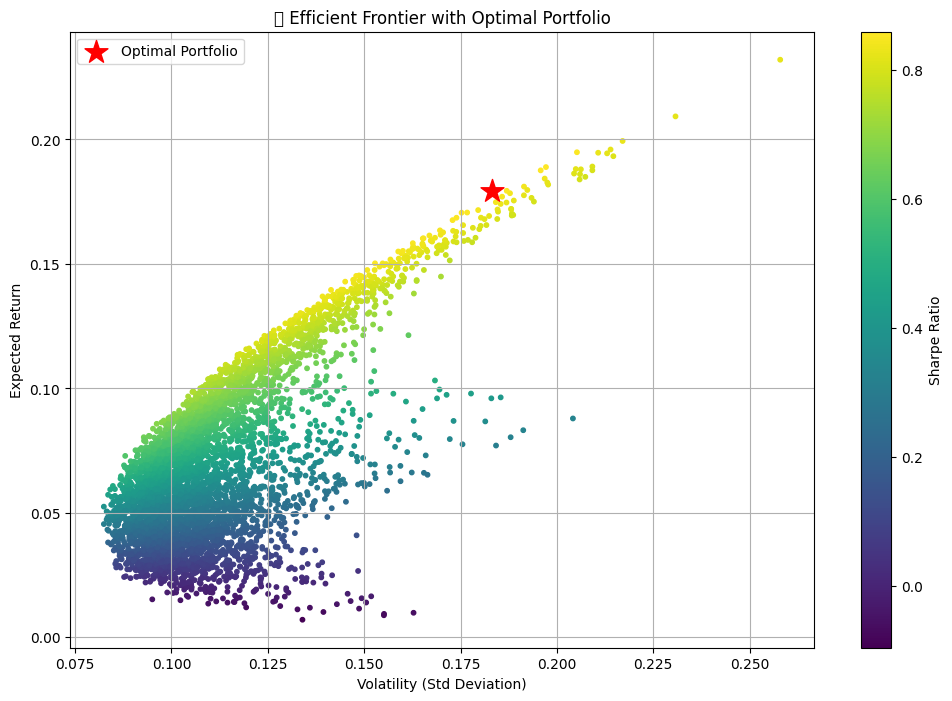

In [169]:
# --- Simulate random portfolios for Efficient Frontier ---------------
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weight_array = []

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
    weight_array.append(weights)
    ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = sharpe

# --- Plot Efficient Frontier -----------------------------------------
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_volatility, opt_return, marker='*', color='r', s=300, label='Optimal Portfolio')
plt.title('📈 Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (Std Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()